In [1]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from re import findall
mycolors = {"blue": "steelblue", "red":"#a76c6e", "green":"#6a9373", "smoke": "#f2f2f2"}

# Tensorflow
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers, models

In [ ]:
# Setting for matplotlib plots
# plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 10, 6

## ETL

### Load

In [2]:
file_paths = [i.as_posix() for i in (Path.home() /'Desktop/RNN/nlp_getting_started').glob('*.csv')]
file_paths.sort()
file_paths

['C:/Users/ordin/Desktop/RNN/nlp_getting_started/sample_submission.csv',
 'C:/Users/ordin/Desktop/RNN/nlp_getting_started/test.csv',
 'C:/Users/ordin/Desktop/RNN/nlp_getting_started/train.csv']

## EDA

In [3]:
df_test = pd.read_csv(file_paths[1])
df_train = pd.read_csv(file_paths[2])
print(f"Training data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Training data shape: (7613, 5)
Test data shape: (3263, 4)


In [20]:
7613+3263

10876

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


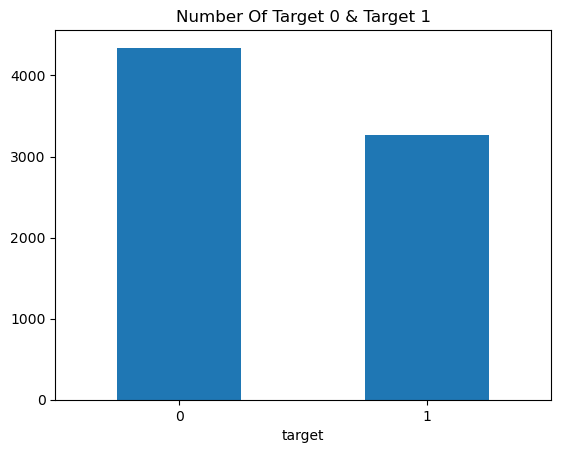

In [7]:
df_train['target'].value_counts().plot(kind = 'bar', title = 'Number Of Target 0 & Target 1', rot = 0);

In [12]:
data.index

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

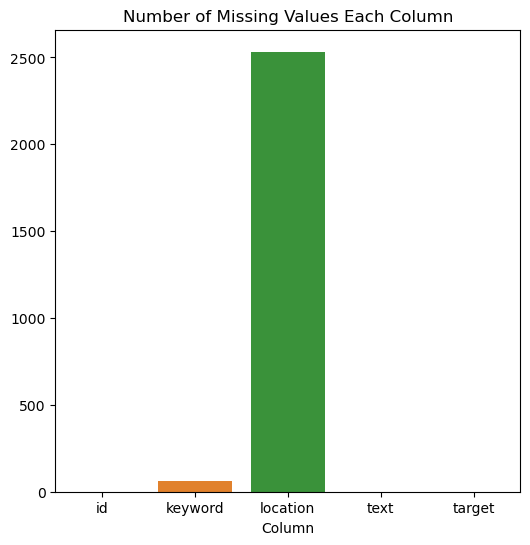

In [19]:
# Missing values
fig, ax = plt.subplots(figsize=(6, 6))
data = np.sum(df_train.isna(), axis=0)
sns.barplot(x=data.index, y=data.values, hue=data.index, ax=ax)
ax.set_title('Number of Missing Values In Each Column (Training)')
ax.set_xlabel('Column');

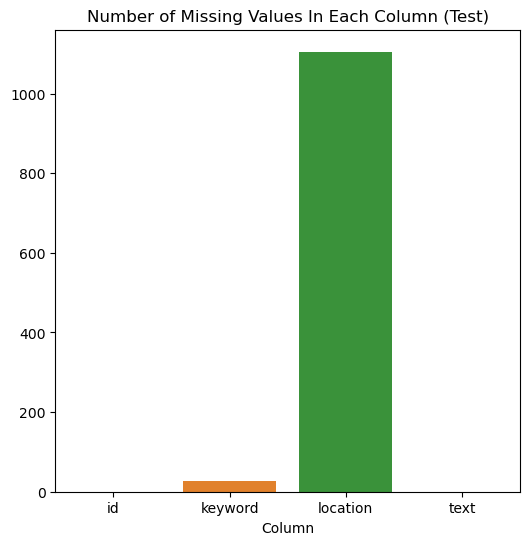

In [20]:
# Missing values
fig, ax = plt.subplots(figsize=(6, 6))
data = np.sum(df_test.isna(), axis=0)
sns.barplot(x=data.index, y=data.values, hue=data.index, ax=ax)
ax.set_title('Number of Missing Values In Each Column (Test)')
ax.set_xlabel('Column');

### Tweet EDA and process

In [ ]:
# EDA and preprocessing
import re
# Functions for tokenization
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import itertools
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [15]:
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [22]:
# Randomly choose five tweets
for i in np.random.choice(df_train.query("target == 1").index, 5):
    print(f"Tweet {i} | target {df_train.target[i]}: {df_train.text[i]}")
print()
for i in np.random.choice(df_train.query("target == 0").index, 5):
    print(f"Tweet {i} | target {df_train.target[i]}: {df_train.text[i]}")

Tweet 3040 | target 1: #USGS M 0.9 - Northern California: Time2015-08-06 01:50:25 UTC2015-08-06 01:50:25 UTC at epicenter... http://t.co/mBo6OAnIQI #EarthTwerk
Tweet 1751 | target 1: Baltimore City : I-95 NORTH AT MP 54.8 (FORT MCHENRY TUNNEL BORE 3: Collision: I-95 NORTH AT MP 54.8 (FORT MCHENRY TUNNEL BORE 3 Nort...
Tweet 5282 | target 1: Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/8lCbDW7m2z
Tweet 2827 | target 1: At least 180 dead a million displaced in India floods - India | ReliefWeb http://t.co/0abgFgLH7X
Tweet 5031 | target 1: @Lolly_Knickers It's a mudslide. 
It's like chewing on a rubber tyre.
And with those I'm DONE.
#vaginaorcake #GBBO

Tweet 3813 | target 0: Loved the way this book was written to include so many vantage points of First Responders @DetKenLang #kindle http://t.co/KcRnMJKJ73
Tweet 2020 | target 0: lmao fuckboy changed his @ for damage control
@Pseudojuuzo
Tweet 5549 | target 0: 

In [ ]:
# Number of news in each category: 
print("Number of news in each category (Training data): ")
print(df_train.groupby('category').size())

In [17]:
df_train['location'].duplicated().sum()

4271

In [19]:
# Number of tweets in each category: 
print("Number of tweets in each location (Training data): ")
print(df_train.groupby('location').size())

Number of tweets in each location (Training data): 
location
                          1
  Glasgow                 1
  Melbourne, Australia    1
  News                    1
  å_                      1
                         ..
å_: ?? ÌÑ ? : ?           1
å_å_Los Mina Cityã¢      1
å¡å¡Midwest Û¢Û¢        1
åÊ(?Û¢`?Û¢å«)??         1
åø\_(?)_/åø               1
Length: 3341, dtype: int64


In [14]:
# Number of tweets in each category: 
print("Number of tweets in each location (Training data): ")
print(df_train.groupby('keyword').size())

Number of tweets in each location (Training data): 
keyword
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Length: 221, dtype: int64


In [25]:
df_train['location'].dropna().duplicated().sum()

1739

In [16]:
df_train['keyword'].dropna().duplicated().sum()

7331

In [27]:
loc_clean = df_train['location'].dropna().apply(lambda x: ''.join(letter for letter in x if letter.isalnum()))
# print(test_str))

In [33]:
type(loc_clean)

pandas.core.series.Series

In [35]:
for i in loc_clean:
    print(i)

Birmingham
EstSeptember2012Bristol
AFRICA
PhiladelphiaPA
LondonUK
Pretoria
WorldWide
ParanaqueCity
LiveOnWebcam
milkyway
GREENSBORONORTHCAROLINA
LiveOnWebcam
England
SheffieldTownshipOhio
India
Barbados
Anaheim
Abuja
USA
SouthAfrica
SaoPauloBrazil
hollywoodland
EdmontonAlbertaTreaty6
InangPamantasan
TwitterLockoutinprogress
ConcordCA
CalgaryAB
Birmingham
SanFrancisco
CLVLND
NashvilleTN
SantaClaraCA
UK
StLouisMO
WalkerCountyAlabama
Australia
NorthCarolina
NorfCarolina
SanMateoCountyCA
NorthCarolina
NjoroKenya
YourSistersBedroom
ArlingtonTX
SouthBloomfieldOH
NewHanoverCountyNC
Maldives
ManchesterNH
WilmingtonNC
NewHanoverCountyNC
global
AlbertaSaskMontana
Charlotte
BatonRougeLA
HagerstownMD
GloucestershireUK
UK
NairobiKenya
Instagramheyimginog
304
Switzerland
304
US
304
Instagramheyimginog
304
SomewhereOnlyWeKnow
Belgium
Switzerland
US
dopeshow
Switzerland
Switzerland
OshawaCanada
BakerCityOregon
UnitedStates
304
304
marysvilleca
304
HermosaBeachCA
304
304
1960085899047821
Pennsylvania
S

In [31]:
loc_clean.shape

(5080,)

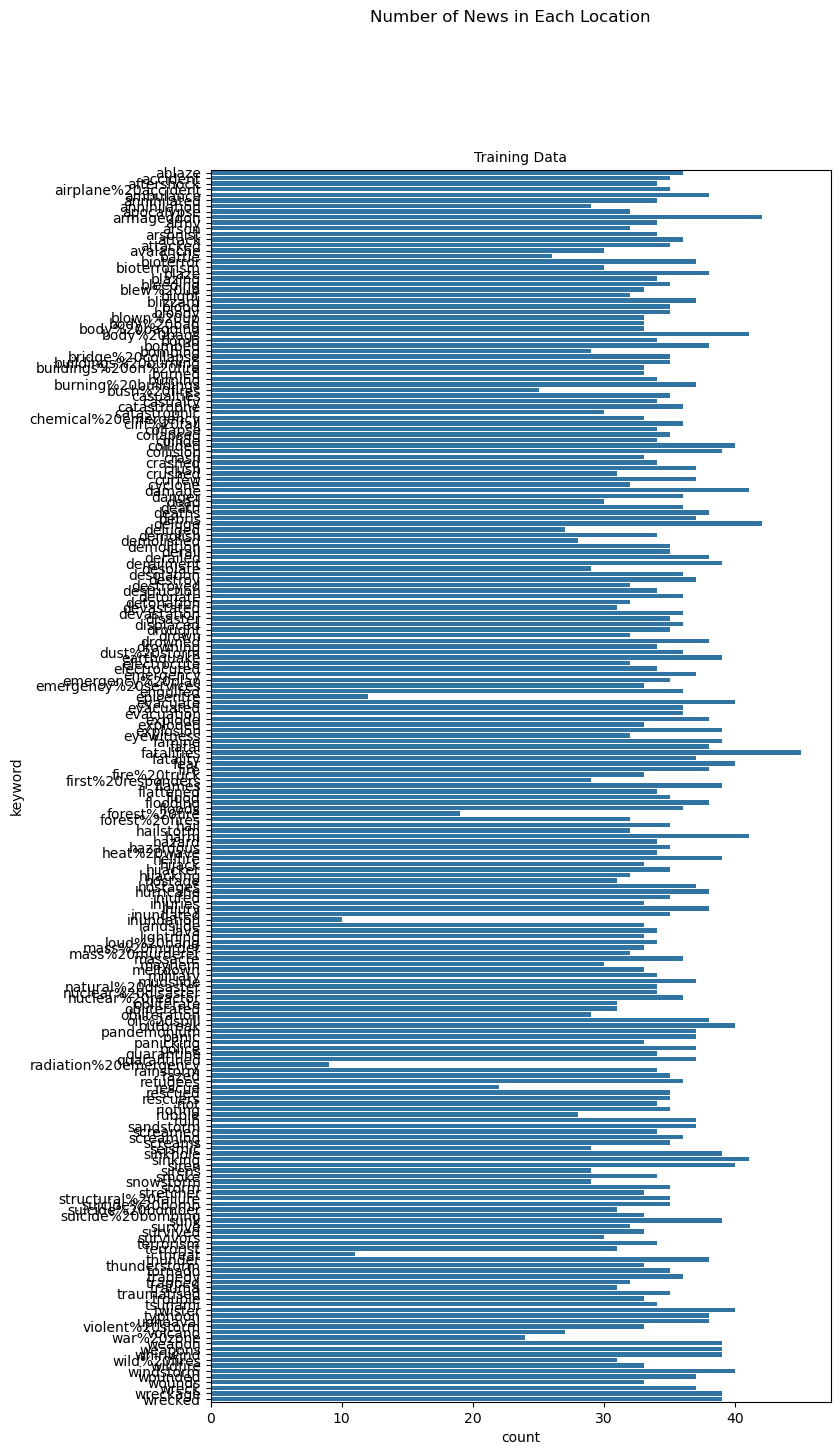

In [19]:
# Plot: Number of news in each category
fig, ax = plt.subplots(figsize = (8, 16))

sns.countplot(y = 'keyword', data = df_train, ax = ax)
fig.suptitle('Number of News in Each Location')
ax.set_title('Training Data', fontdict = dict(size = 10));

### Apply NLP

In [6]:
# Import needed package,
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')
from string import punctuation
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize


# Initialize a lemmatizer
wnl = WordNetLemmatizer()

# Function for converting Penn Treebank tags in order to fit the format WordNet Lemmatizer
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' # if mapping isn't found, fall back to Noun.

# Function for preprocessing
def preprocessing(text):

    # Get word tokens
    word_tokens = word_tokenize(text)
    
    # Remove stop words and lowercasing
    stopwords_removed_lower_text = [word.lower() for word in word_tokens if word not in stopwords_en]
    
    # We can utilize set operation to remove punctuations in the previous cleaned text
    punc_stopwords_removed_lower_text = list(set(stopwords_removed_lower_text) - set(punctuation))

    # With tagging, we can utilize the lemmatize()
    preprocessed_text = [wnl.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(punc_stopwords_removed_lower_text)]

    # Raw documents format for TF-IDF
    preprocessed_text = " ".join(preprocessed_text)

    return preprocessed_text

In [7]:
# Apply the function to the dataset and create a new column to store the results
df_train['cleaned_tweet'] = df_train['text'].apply(lambda text: preprocessing(text))
df_train['number_of_words'] = df_train['cleaned_tweet'].apply(lambda text: len(text.split()))
# See the results
df_train.head()

,id,keyword,location,text,target,cleaned_tweet,number_of_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,allah forgive our deed u may earthquake reason,8
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,canada ronge sask near forest la fire,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident shelter order notify expect all evacu...,12
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"wildfire california 13,000 receive order evacu...",7
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just get wildfire send pours photo smoke alask...,10


In [11]:
# Apply the function to the dataset and create a new column to store the results
df_test['cleaned_tweet'] = df_test['text'].apply(lambda text: preprocessing(text))
df_test['number_of_words'] = df_test['cleaned_tweet'].apply(lambda text: len(text.split()))
# See the results
df_test.head()

,id,keyword,location,text,cleaned_tweet,number_of_words
0,0,NaN,NaN,Just happened a terrible car crash,just crash car happen terrible,5
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",stay safe earthquake everyone city hear different,7
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",street save geese across forest spot i flee po...,10
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,spokane wildfire apocalypse light,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon taiwan kill 28 china soudelor,6


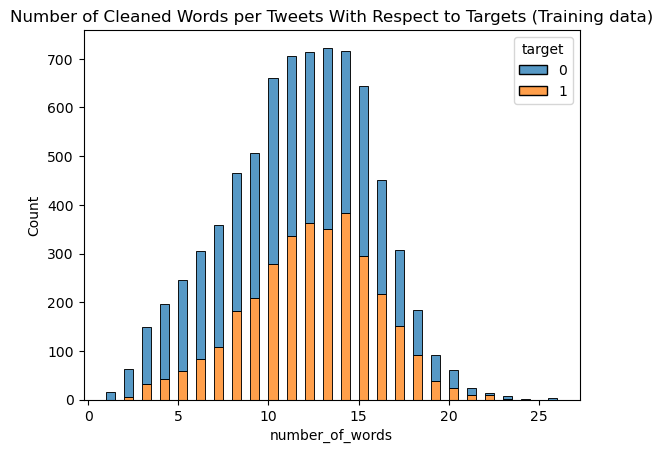

In [10]:
# How the number of words distributed
sns.histplot(
    df_train, 
    x = "number_of_words", 
    hue = "target", 
    multiple="stack").set(
        title = 'Number of Cleaned Words per Tweets With Respect to Targets (Training data)');

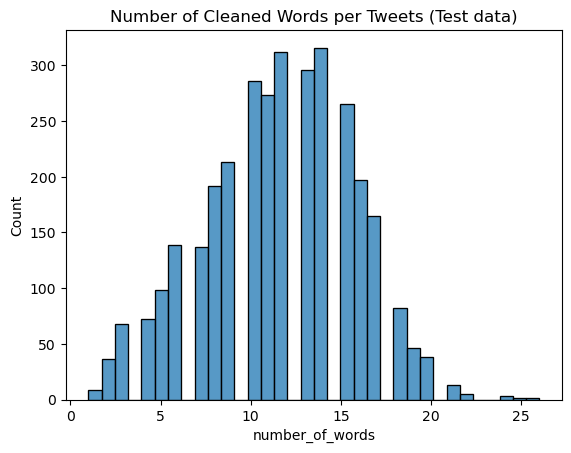

In [13]:
# How the number of words distributed
sns.histplot(
    df_test, 
    x = "number_of_words", 
    # hue = "target", 
    multiple="stack").set(
        title = 'Number of Cleaned Words per Tweets (Test data)');

### Building Vectors

* We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process. 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [28]:
count_vectorizer = CountVectorizer()

# Example vectors
example_train_vectors = count_vectorizer.fit_transform(df_train['cleaned_tweet'][0:5])

In [29]:
# We use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 40)
[[0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0]]


In [30]:
# We use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[1].todense().shape)
print(example_train_vectors[1].todense())

(1, 40)
[[0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
  0 0 0 0]]


In [31]:
train_vectors = count_vectorizer.fit_transform(df_train['cleaned_tweet'])
# Using just .transform() makes sure that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(df_test['cleaned_tweet'])


In [33]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

In [35]:
scores = model_selection.cross_val_score(clf, train_vectors, df_train["target"], cv=5, scoring="f1")
scores

array([0.57984791, 0.50666667, 0.58079625, 0.58596491, 0.68058778])

### TF-IDF

In [38]:
# Packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

# Define a pipeline combining a text feature vectorizer with a simple classifier yet effective for text classification.
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", ComplementNB()),
    ]
)
pipeline

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])

In [36]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}

In this case `n_iter=40` is not an exhaustive search of the hyperparameters’ grid. __In practice it would be interesting to increase the parameter `n_iter` to get a more informative analysis__. As a consequence, the computional time increases. We can reduce it by taking advantage of the parallelisation over the parameter combinations evaluation by increasing the number of CPUs used via the parameter `n_jobs`.

In [39]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=80, # Documentation : 40
    random_state=0,
    n_jobs=-1,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (1, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__norm': ('l1', 'l2')}


In [41]:
from time import time

# Apply random search on training data
t0 = time()
random_search.fit(df_train['cleaned_tweet'], df_train['target'])
print(f"Done in {time() - t0:.3f}s")

Fitting 5 folds for each of 80 candidates, totalling 400 fits


Done in 7.526s


In [42]:
# Best parameters for training data
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__alpha: 10.0
vect__max_df: 0.2
vect__min_df: 1
vect__ngram_range: (1, 1)
vect__norm: l2


In [43]:
# Accuracy of the best parameter for training data
test_accuracy = random_search.score(df_train['cleaned_tweet'], df_train['target'])
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.709
Accuracy on test set: 0.853


In [44]:
# The prefixes vect and clf are required to avoid possible ambiguities in the pipeline, but are not necessary for visualizing the results. 
# Because of this, we define a function that will rename the tuned hyperparameters and improve the readability.

def shorten_param(param_name):
    """Remove components' prefixes in param_name."""
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = pd.DataFrame(random_search.cv_results_)
cv_results = cv_results.rename(shorten_param, axis=1)

In [45]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,norm,ngram_range,min_df,max_df,alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.152078,0.005981,0.022066,0.004912,l2,"(1, 2)",3,1.0,10.0,"{'vect__norm': 'l2', 'vect__ngram_range': (1, ...",0.694682,0.666448,0.688116,0.691853,0.760841,0.700388,0.031820,11
1,0.132074,0.032037,0.022842,0.008184,l2,"(1, 2)",3,0.6,100.0,"{'vect__norm': 'l2', 'vect__ngram_range': (1, ...",0.686802,0.656599,0.694682,0.693824,0.764783,0.699338,0.035550,14
2,0.055380,0.006975,0.011737,0.001364,l1,"(1, 1)",10,0.6,0.01,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.660538,0.603414,0.636901,0.645861,0.721419,0.653627,0.038743,79
3,0.111468,0.011263,0.018971,0.004496,l2,"(1, 2)",10,1.0,0.001,"{'vect__norm': 'l2', 'vect__ngram_range': (1, ...",0.669731,0.606697,0.648063,0.659001,0.737188,0.664136,0.042313,67
4,0.117206,0.016375,0.021687,0.005641,l2,"(1, 2)",3,0.2,1.0,"{'vect__norm': 'l2', 'vect__ngram_range': (1, ...",0.691399,0.656599,0.704531,0.705650,0.747700,0.701176,0.029252,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.099054,0.006658,0.018783,0.004012,l1,"(1, 2)",10,1.0,10.0,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.692712,0.662508,0.688116,0.657687,0.754928,0.691190,0.034697,28
76,0.051543,0.002068,0.012317,0.002316,l1,"(1, 1)",10,0.4,0.00001,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.669731,0.613920,0.642810,0.653745,0.718791,0.659799,0.034667,72
77,0.102410,0.009582,0.016492,0.000876,l1,"(1, 2)",3,0.2,0.1,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.697965,0.634931,0.689429,0.711564,0.730618,0.692901,0.032153,26
78,0.100397,0.009980,0.016826,0.001316,l1,"(1, 2)",10,0.8,0.1,"{'vect__norm': 'l1', 'vect__ngram_range': (1, ...",0.669731,0.611950,0.652003,0.646518,0.729961,0.662032,0.038789,69


In [47]:
import plotly.express as px

param_names = [shorten_param(name) for name in parameter_grid.keys()]
labels = {
    "mean_score_time": "CV Score time (s)",
    "mean_test_score": "CV score (accuracy)",
}
fig = px.scatter(
    cv_results,
    x="mean_score_time",
    y="mean_test_score",
    error_x="std_score_time",
    error_y="std_test_score",
    hover_data=param_names,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "trade-off between scoring time and mean test score",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

In [48]:
from math import log10

column_results = param_names + ["mean_test_score", "mean_score_time"]

transform_funcs = dict.fromkeys(column_results, lambda x: x)
# Using a logarithmic scale for alpha
transform_funcs["alpha"] = log10
# L1 norms are mapped to index 1, and L2 norms to index 2
transform_funcs["norm"] = lambda x: 2 if x == "l2" else 1
# Unigrams are mapped to index 1 and bigrams to index 2
transform_funcs["ngram_range"] = lambda x: x[1]

fig = px.parallel_coordinates(
    cv_results[column_results].apply(transform_funcs),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis_r,
    labels=labels,
)
fig.update_layout(
    title={
        "text": "Parallel coordinates plot of text classifier pipeline",
        "y": 0.99,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    }
)
fig

In [49]:
# Print the best parameters again
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__alpha: 10.0
vect__max_df: 0.2
vect__min_df: 1
vect__ngram_range: (1, 1)
vect__norm: l2


In [50]:
# Use the best parameters found by the pipeline
tfidf_vect = TfidfVectorizer(
    max_df = 0.2,
    min_df = 1,
    ngram_range = (1, 1),
    norm = 'l2',
    stop_words = 'english')

tfidf_vect_train = tfidf_vect.fit_transform(df_train['cleaned_tweet'].values)
tfidf_vect_test = tfidf_vect.transform(df_test['cleaned_tweet'].values)

print(f"TF-IDF vector of training data: {tfidf_vect_train.shape}")
print(f"TF-IDF vector of testing data: {tfidf_vect_test.shape}")
# tfidvec_test = tfidvec.fit_transform(df_test['cleaned_text'].values)
# print(f"TF-IDF vector of testing data: {tfidvec_test.shape}")

TF-IDF vector of training data: (7613, 19598)
TF-IDF vector of testing data: (3263, 19598)


In [51]:

clf = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(clf, tfidf_vect_train, df_train["target"], cv=5, scoring="f1")
scores

array([0.52878049, 0.51826678, 0.54591837, 0.53584906, 0.69015212])

## Modeling

### Keras BERT pretrained model

In [4]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [5]:
# Training and validation dataset split
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [8]:
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

Using TensorFlow backend


In [ ]:
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased"
)
preprocessor(["The quick brown fox jumped.", "Call me Ishmael."])

# Custom vocabulary.
vocab = ["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
vocab += ["The", "quick", "brown", "fox", "jumped", "."]
tokenizer = keras_nlp.models.DistilBertTokenizer(vocabulary=vocab)
preprocessor = keras_nlp.models.DistilBertPreprocessor(tokenizer)
preprocessor("The quick brown fox jumped.")

In [13]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased", 
    num_classes=2,
)

100%|██████████| 510/510 [00:00<?, ?B/s] 


AttributeError: 'types.SimpleNamespace' object has no attribute 'get_registered_object'

In [12]:
tf.keras.__version__

'2.10.0'

In [10]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
    sequence_length=160,
    name="preprocessor_4_tweets"
    )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
    preprocessor = preprocessor, 
    num_classes=2)

classifier.summary()

AttributeError: 'types.SimpleNamespace' object has no attribute 'get_registered_object'

In [ ]:
### Building an image data pipeline

# Create the dataset from slices of the file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((df_train['text'].values, df_train['target'].values))
# Shuffle the data with a buffer size equal to the length of the dataset. This ensures good shuffling
dataset = dataset.shuffle(len(df_train))

# Train / validation set split
val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

## Training & Validation dataset split
# Parse the images from filename to the pixel values.
train_ds = train_ds.map(parse_function, num_parallel_calls=4) # Use multiple threads to improve the speed of preprocessing
val_ds = val_ds.map(parse_function, num_parallel_calls=4) 

# Data augmentation
# train_ds = train_ds.map(data_augmentation, num_parallel_calls = 4)
# val_ds = val_ds.map(data_augmentation, num_parallel_calls = 4)

# Traing batch and steps
num_train_samples = tf.data.experimental.cardinality(train_ds).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds).numpy()
train_batch_size = 32
val_batch_size = 32
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

print(f"Number of training images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")

In [ ]:
# Traing, validation, test dataset split
train_split=0.8
val_split=0.1
test_split=0.1
ds_size = df_subset.shape[0]

# Create the dataset from slices of the file paths and labels
sub_dataset = tf.data.Dataset.from_tensor_slices((df_subset['path'].values, df_subset['label'].values))
# Shuffle the data with a buffer size equal to the length of the dataset.
sub_dataset = sub_dataset.shuffle(ds_size)

# Train, validation, test set split
train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)

sub_train_ds = sub_dataset.take(train_size)
sub_val_ds = sub_dataset.skip(train_size).take(val_size)
sub_test_ds = sub_dataset.skip(train_size).skip(val_size)

## Training & Validation dataset split
# Parse the images from filename to the pixel values.
sub_train_ds = sub_train_ds.map(parse_function, num_parallel_calls=4) # Use multiple threads to improve the speed of preprocessing
sub_val_ds = sub_val_ds.map(parse_function, num_parallel_calls=4) 
sub_test_ds = sub_test_ds.map(parse_function, num_parallel_calls=4) 

# Data augmentation
# sub_train_ds = sub_train_ds.map(data_augmentation, num_parallel_calls = 4)
# sub_val_ds = sub_val_ds.map(data_augmentation, num_parallel_calls = 4)

# Traing batch and steps
num_train_samples = tf.data.experimental.cardinality(sub_train_ds).numpy()
num_val_samples = tf.data.experimental.cardinality(sub_val_ds).numpy()
num_test_samples = tf.data.experimental.cardinality(sub_test_ds).numpy()
batch_size = 32
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

sub_train_ds = sub_train_ds.batch(batch_size)
sub_train_ds = sub_train_ds.prefetch(1)
sub_val_ds = sub_val_ds.batch(batch_size)
sub_val_ds = sub_val_ds.prefetch(1)
sub_test_ds = sub_test_ds.batch(batch_size)
sub_test_ds = sub_test_ds.prefetch(1)

print(f"Amount of subset dataset: {ds_size}")
print(f"Number of training images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")
print(f"Number of test images: {num_test_samples}")

In [ ]:
# Parse the images from filename to the pixel values
def parse_function(file_name, label):

    # Read the content of the file
    img_string = tf.io.read_file(file_name)
    # Decode tiff image
    img = tfio.experimental.image.decode_tiff(img_string)
    # Since decode_tiff() returns RGBA tensor, and we only need 3 channel, we just extract RGB from the tensor
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    # Combine RGB together
    img = tf.stack([r, g, b], axis = -1) # -1 means last dimension
    # Standardize, convert to float values in [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img, label

# Data augmentation for the images
def data_augmentation(image, label):
    
    # Horizontally flip the image with probability 1/2
    image = tf.image.random_flip_left_right(image)

    # Apply random brightness and saturation
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

### Data split

## Last